<a href="https://colab.research.google.com/github/Dyuko/Natural_Language_To_Sql/blob/main/tp2_tp_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema de Consulta SQL con LLM
Este notebook implementa un sistema de consulta en lenguaje natural para una base de datos SQLite (Chinook)
utilizando un modelo de lenguaje (LLM) para convertir preguntas en consultas SQL.

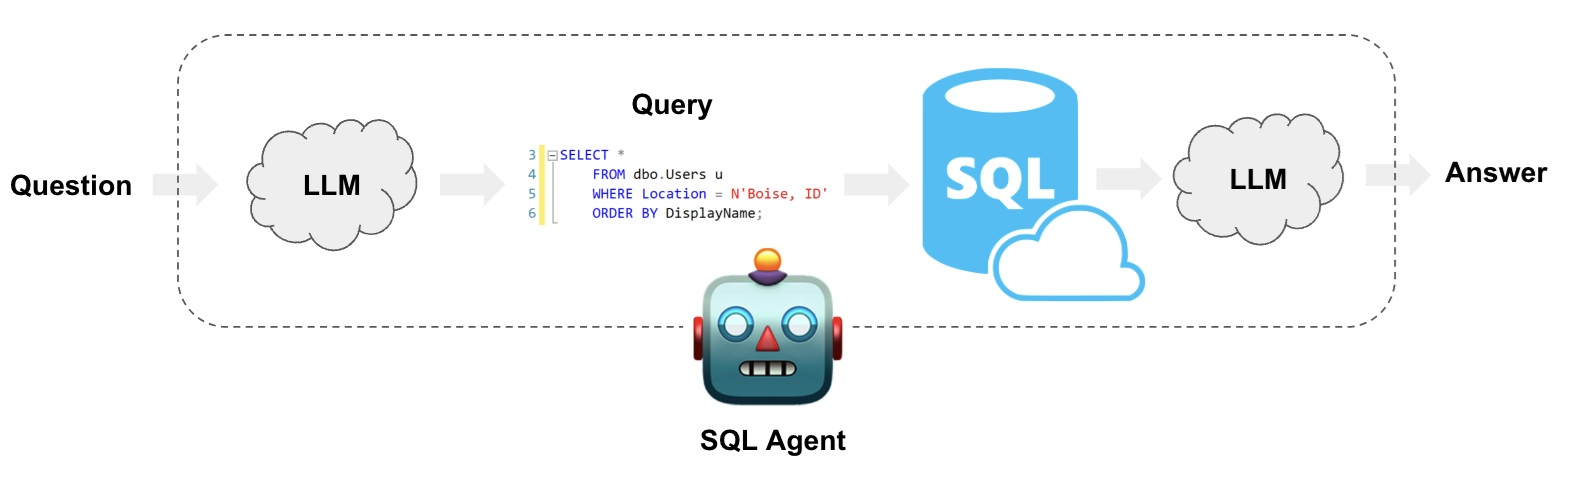

Utiliza como ejemplo la base de datos SQL Chinook.

La base de datos Chinook es una base de datos de ejemplo ampliamente utilizada para prácticas y aprendizaje en el manejo de bases de datos relacionales. Está diseñada para representar un sistema de gestión de una tienda de música digital

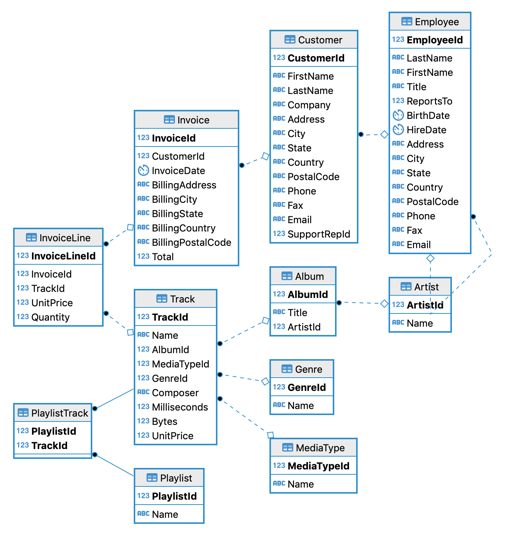

### Instalación de bibliotecas necesarias

In [1]:
!pip install -qU langchain-huggingface
!pip install -qU langchain-core
!pip install faiss-cpu
!pip install python-dotenv
!pip install langchain-community
!pip install langgraph
!pip install -U langchain-groq

### Importación de bibliotecas

In [2]:
import dotenv
import os
import ast
import re
from google.colab import drive
from langchain_community.utilities import SQLDatabase
from langgraph.prebuilt import create_react_agent
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain.chat_models import init_chat_model
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain.agents.agent_toolkits import create_retriever_tool
from langchain_core.messages import HumanMessage

### Montar Google Drive para acceder a archivos

In [3]:
drive.mount('/content/drive')
path = '/content/drive/MyDrive/tp2_tpfinal/Chinook_v2.db'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Cargar variables de entorno

In [4]:
dotenv.load_dotenv('/content/drive/MyDrive/.env')
api_key = os.environ.get('GROP_API_KEY')

### Inicializar la conexión a la base de datos SQLite

In [5]:
db = SQLDatabase.from_uri(f'sqlite:///{path}')

### Mostrar información sobre la base de datos

In [6]:
print(db.dialect)
print(db.get_usable_table_names())

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


### Ejemplo de consulta a la base de datos

In [7]:
db.run("SELECT * FROM Artist LIMIT 10;")

"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

### Inicializar el modelo de lenguaje (Llama) con Groq como proveedor

In [8]:
#llm = init_chat_model("llama3-8b-8192", model_provider="groq", api_key=api_key ) #Observación: Supera los tokens disponibles por minuto
llm = init_chat_model("meta-llama/llama-4-scout-17b-16e-instruct", model_provider="groq", api_key=api_key )

### Configurar embeddings

In [9]:
# Configuración del modelo de embeddings para representar texto como vectores
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### Definir ejemplos few-shot y crear índice FAISS

In [10]:
# Ejemplos de pares (pregunta en lenguaje natural, consulta SQL equivalente)
# Estos ejemplos servirán como referencia para el LLM mediante few-shot learning
examples = [
    {"input": "List all artists.", "query": "SELECT * FROM Artist;"},
    {
        "input": "Find all albums for the Artist 'AC/DC'.",
        "query": "SELECT * FROM Album WHERE ArtistId = (SELECT ArtistId FROM Artist WHERE Name = 'AC/DC');",
    },
    {
        "input": "List all tracks in the 'Rock' genre.",
        "query": "SELECT * FROM Track WHERE GenreId = (SELECT GenreId FROM Genre WHERE Name = 'Rock');",
    },
    {
        "input": "Find the total duration of all tracks.",
        "query": "SELECT SUM(Milliseconds) FROM Track;",
    },
    {
        "input": "List all customers from Canada.",
        "query": "SELECT * FROM Customer WHERE Country = 'Canada';",
    },
    {
        "input": "How many tracks are there in the album with ID 5?",
        "query": "SELECT COUNT(*) FROM Track WHERE AlbumId = 5;",
    },
    {
        "input": "Find the total number of invoices.",
        "query": "SELECT COUNT(*) FROM Invoice;",
    },
    {
        "input": "List all tracks that are longer than 5 minutes.",
        "query": "SELECT * FROM Track WHERE Milliseconds > 300000;",
    },
    {
        "input": "Who are the top 5 customers by total purchase?",
        "query": "SELECT CustomerId, SUM(Total) AS TotalPurchase FROM Invoice GROUP BY CustomerId ORDER BY TotalPurchase DESC LIMIT 5;",
    },
    {
        "input": "Which albums are from the year 2000?",
        "query": "SELECT * FROM Album WHERE strftime('%Y', ReleaseDate) = '2000';",
    },
    {
        "input": "How many employees are there",
        "query": 'SELECT COUNT(*) FROM "Employee"',
    },
]

### Convertir ejemplos a textos indexables

In [11]:
# Formateo de los ejemplos para su indexación en FAISS
example_texts = [f"Input: {ex['input']}\nSQL Query: {ex['query']}" for ex in examples]
# Creación del índice FAISS para búsqueda eficiente de ejemplos similares
example_store = FAISS.from_texts(example_texts, embeddings)
# Configuración del recuperador para obtener los 2 ejemplos más similares a una consulta
example_retriever = example_store.as_retriever(search_kwargs={"k": 2})

In [12]:
# Testing Retriever de Ejemplos
example_retriever.get_relevant_documents("Which albums are from the year 2005?")

<ipython-input-12-d79009796318>:2: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  example_retriever.get_relevant_documents("Which albums are from the year 2005?")


[Document(id='fbc57470-263e-4788-87b2-69dfe673c0bc', metadata={}, page_content="Input: Which albums are from the year 2000?\nSQL Query: SELECT * FROM Album WHERE strftime('%Y', ReleaseDate) = '2000';"),
 Document(id='3621980d-99ed-426d-8db8-8e79b47fc032', metadata={}, page_content="Input: Find all albums for the Artist 'AC/DC'.\nSQL Query: SELECT * FROM Album WHERE ArtistId = (SELECT ArtistId FROM Artist WHERE Name = 'AC/DC');")]

### Función auxiliar para convertir resultados de consultas SQL en listas limpias

In [13]:
def query_as_list(db, query):
    """
    Convierte el resultado de una consulta SQL en una lista limpia de strings.

    Args:
        db (SQLDatabase): La base de datos donde ejecutar la consulta
        query (str): La consulta SQL a ejecutar

    Returns:
        list: Lista de strings con los resultados limpios (sin duplicados y sin números)
    """
    # Ejecutar la consulta en la base de datos
    res = db.run(query)

    # Convertir el resultado (string) a una estructura de datos Python y aplanar la lista
    res = [el for sub in ast.literal_eval(res) for el in sub if el]

    # Eliminar números y espacios extra de cada string
    res = [re.sub(r"\b\d+\b", "", string).strip() for string in res]

    # Devolver lista sin duplicados
    return list(set(res))

### Obtener nombres de artistas y álbumes para el sistema de recuperación

In [14]:
# Extracción de nombres de artistas y álbumes de la base de datos
# Estos se usarán para buscar coincidencias cuando se mencionen en las consultas
artists = query_as_list(db, "SELECT Name FROM Artist")
albums = query_as_list(db, "SELECT Title FROM Album")

### Crear vector store para nombres propios usando FAISS

In [15]:
# Creación de un índice FAISS para la búsqueda eficiente de nombres propios
proper_noun_store = FAISS.from_texts(artists + albums, embeddings)
retriever = proper_noun_store.as_retriever(search_kwargs={"k": 5})

In [16]:
# Testing Retriever de nombres propios
retriever.get_relevant_documents("What albums does AC DC own?")

[Document(id='17127d4c-b439-4601-8691-3e5d1cbb1521', metadata={}, page_content='AC/DC'),
 Document(id='ef364e84-44e3-404e-8f54-52c01ae9d779', metadata={}, page_content='The Final Concerts (Disc )'),
 Document(id='415aabbd-89af-4675-a0d2-5f9b9e50c5d0', metadata={}, page_content='Greatest Hits'),
 Document(id='689445ba-46b9-49ed-83b5-839fa7a112b7', metadata={}, page_content='Various Artists'),
 Document(id='1787d267-cff0-4ae6-a19c-4563df54f289', metadata={}, page_content='Pink Floyd')]

### Configurar herramienta de recuperación para nombres propios

In [17]:
# Descripción de la herramienta para buscar nombres propios
proper_noun_description  = (
    "Use to look up values to filter on. Input is an approximate spelling "
    "of the proper noun, output is valid proper nouns. Use the noun most "
    "similar to the search."
)

# Creación de la herramienta de recuperación para nombres propios
retriever_tool = create_retriever_tool(
    retriever,
    name="search_proper_nouns",
    description=proper_noun_description ,
)

### Configurar herramienta de recuperación de ejemplos sql

In [18]:
# Descripción de la herramienta para recuperar ejemplos de consultas SQL
example_description = (
"Use to get examples of similar SQL queries. "
"Input should be a natural language question about the database. "
"Output will be example questions and their corresponding SQL queries."
)

# Creación de la herramienta de recuperación para ejemplos SQL
example_retriever_tool = create_retriever_tool(
    example_retriever,
    name="retrieve_sql_examples",
    description=example_description,
)

### Inicializar el toolkit para SQL con la base de datos y el modelo LLM

In [19]:
# Creación del toolkit que proporciona herramientas para interactuar con la base de datos
toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()

### Añadir la herramientas de recuperación a las herramientas disponibles

In [20]:
# Agregar las nuevas herramientas a la lista de herramientas disponibles
tools.extend([retriever_tool, example_retriever_tool])

### System Prompt base

In [26]:
# Prompt de sistema que guía al modelo en cómo responder a las preguntas
# Define un orden específico de pasos y reglas para generar consultas SQL correctas
base_system_message = """Follow THIS ORDER to answer the question:
1. Use tool 'sql_db_list_tables' (available tables)
2. Use tool 'sql_db_schema' (structure of relevant tables)
3. Use tool 'retrieve_sql_examples' (similar examples)
4. If the query refers to a proper noun, use tool 'search_proper_nouns'

Key rules:
- Do NOT use tables not listed in sql_db_list_tables or columns not in sql_db_schema
- Limit results to {top_k} (unless specified otherwise)
- NEVER perform DML (INSERT/UPDATE/DELETE)
- Verify queries before execution
- For proper nouns, ALWAYS use the 'search_proper_nouns' tool

Concise example flow:
1. List tables → 2. Check schema → 3. Retrieve examples → [4. Proper nouns if needed] → 5. Query executed with SQLite
""".format(top_k=5)

#### Crear agente con el prompt base y los tools

In [27]:
agent = create_react_agent(llm, tools, prompt=base_system_message)

### Internal Debug

In [28]:
def answer(question):
    """
    Función para pruebas internas que ejecuta el agente y muestra todos los pasos de razonamiento.

    Args:
        question (str): La pregunta del usuario sobre la base de datos

    Returns:
        None: Imprime cada paso del proceso de razonamiento
    """
    # Crear agente con el prompt actualizado y modo debug activado
    agent = create_react_agent(llm, tools, prompt=base_system_message, debug=True)

    # Ejecutar el agente en modo stream para ver cada paso
    for step in agent.stream(
        {"messages": [{"role": "user", "content": question}]},
        stream_mode="values",
    ):
        step["messages"][-1].pretty_print()  # Imprimir cada mensaje generado

In [29]:
# Debugging
answer("List all songs from AC CD")

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [{'content': 'List all songs from AC CD', 'role': 'user'}]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [{'content': 'List all songs from AC CD', 'role': 'user'}]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='List all songs from AC CD', additional_kwargs={}, response_metadata={}, id='3adfe649-3c69-490b-bf87-e7f71924ff8e')]}
[1:tasks] Starting 1 task for step 1:
- agent -> {'is_last_step': False,
 'messages': [HumanMessage(content='List all songs from AC CD', additional_kwargs={}, response_metadata={}, id='3adfe649-3c69-490b-bf87-e7f71924ff8e')],
 'remaining_steps': 24}
================================ Human Message =================================

List all songs from AC CD
[1:writes] Finished step 1 with writes to 1 channel:
- messages -> [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '

### Función final para realizar preguntas

In [30]:
def pretty_answer(question):
    """
    Función principal simplificada que recibe una pregunta y devuelve la respuesta del agente.

    Utiliza el método invoke() en lugar de stream() para obtener directamente el resultado final.

    Args:
        question (str): La pregunta del usuario sobre la base de datos

    Returns:
        str: La respuesta generada por el agente (solo el contenido final)
    """
    try:
        # Preparar la entrada y ejecutar el agente de forma directa
        input_data = {"messages": [{"role": "user", "content": question}]}
        result = agent.invoke(input_data)

        # Obtener el último mensaje (respuesta final)
        final_response = result["messages"][-1].content

        return final_response

    except Exception as e:
        return f"Error al procesar la pregunta: {str(e)}"

# Función para imprimir de forma elegante
def print_answer(question):
    """
    Imprime la pregunta y respuesta con formato claro y separación visual

    Args:
        question (str): Pregunta a mostrar
    """
    print("═" * 80)
    print(f"❓ Pregunta: {question}")
    print("─" * 80)
    response = pretty_answer(question)
    print(f"💡 Respuesta:\n{response}")
    print("═" * 80 + "\n")

### Realizar preguntas de prueba

#### Pregunta 1

In [31]:
print_answer("Which country's customers spent the most?")

════════════════════════════════════════════════════════════════════════════════
❓ Pregunta: Which country's customers spent the most?
────────────────────────────────────────────────────────────────────────────────
💡 Respuesta:
The country whose customers spent the most is the USA, with a total of $523.06.
════════════════════════════════════════════════════════════════════════════════



In [ ]:
# Solución:
db.run("SELECT Country, SUM(Total) AS TotalPurchase FROM Invoice JOIN Customer ON Invoice.CustomerId = Customer.CustomerId GROUP BY Country ORDER BY TotalPurchase DESC LIMIT 1")

"[('USA', 523.0600000000003)]"

#### Pregunta 2

In [ ]:
print_answer("List all albums by AC/DC")

════════════════════════════════════════════════════════════════════════════════
❓ Pregunta: List all albums by AC/DC
────────────────────────────────────────────────────────────────────────────────
💡 Respuesta:
The albums by AC/DC are:

1. For Those About To Rock We Salute You
2. Let There Be Rock
════════════════════════════════════════════════════════════════════════════════



In [ ]:
# Solución:
db.run("SELECT * FROM Album WHERE ArtistId = (SELECT ArtistId FROM Artist WHERE Name = 'AC/DC')")

"[(1, 'For Those About To Rock We Salute You', 1), (4, 'Let There Be Rock', 1)]"

#### Pregunta 3

In [ ]:
print_answer("What is the average duration of tracks in the Rock genre?")

════════════════════════════════════════════════════════════════════════════════
❓ Pregunta: What is the average duration of tracks in the Rock genre?
────────────────────────────────────────────────────────────────────────────────
💡 Respuesta:
The average duration of tracks in the Rock genre is approximately 283.91 seconds or 4.73 minutes.
════════════════════════════════════════════════════════════════════════════════



In [ ]:
# Solución:
db.run("SELECT AVG(Milliseconds) FROM Track WHERE GenreId = (SELECT GenreId FROM Genre WHERE Name = 'Rock')")

'[(283910.0431765613,)]'

#### Pregunta 4

In [ ]:
print_answer("Which artist has the most albums in the database?")

════════════════════════════════════════════════════════════════════════════════
❓ Pregunta: Which artist has the most albums in the database?
────────────────────────────────────────────────────────────────────────────────
💡 Respuesta:
The artist with the most albums in the database is Iron Maiden with 21 albums.
════════════════════════════════════════════════════════════════════════════════



In [ ]:
# Solución:
db.run("SELECT ar.Name AS ArtistName, COUNT(al.AlbumId) AS AlbumCount FROM Artist ar JOIN Album al ON ar.ArtistId = al.ArtistId GROUP BY ar.Name ORDER BY AlbumCount DESC LIMIT 1;")

"[('Iron Maiden', 21)]"

#### Pregunta 5

In [ ]:
print_answer("Which playlist has the highest number of tracks?")

════════════════════════════════════════════════════════════════════════════════
❓ Pregunta: Which playlist has the highest number of tracks?
────────────────────────────────────────────────────────────────────────────────
💡 Respuesta:
The playlist with the highest number of tracks is "Music".
════════════════════════════════════════════════════════════════════════════════



In [ ]:
# Solución:
db.run("SELECT p.Name AS PlaylistName, COUNT(pt.TrackId) AS TrackCount FROM Playlist p JOIN PlaylistTrack pt ON p.PlaylistId = pt.PlaylistId GROUP BY p.Name ORDER BY TrackCount DESC LIMIT 1;")

"[('Music', 6580)]"